In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"   Using Device: {device}")

try:
    df = pd.read_csv("quantum_dataset.csv")
    print(f"Dataset Loaded: {len(df)} samples found")
except FileNotFoundError:
    print("not found")
    raise


   Using Device: cpu
Dataset Loaded: 10000 samples found


In [ ]:
#Metadata (3) + Low Noise (16) + Mod Noise (16) + High Noise (16)
#Total Input Features = 51
input_cols = ["n_qubits", "n_gates", "depth"]
for level in ["low", "moderate", "high"]:
    for i in range(16):
        input_cols.append(f"{level}_{i}")

target_cols = [f"ideal_{i}" for i in range(16)]

X_numpy = df[input_cols].values.astype(np.float32)
Y_numpy = df[target_cols].values.astype(np.float32)

X_train, X_test, Y_train, Y_test = train_test_split(X_numpy, Y_numpy, test_size=0.2, random_state=42)

X_train_gpu = torch.tensor(X_train).to(device)
Y_train_gpu = torch.tensor(Y_train).to(device)
X_test_gpu = torch.tensor(X_test).to(device)
Y_test_gpu = torch.tensor(Y_test).to(device)

print(f"   Training Data Shape: {X_train.shape}")
print(f"   Testing Data Shape:  {X_test.shape}")

   Training Data Shape: (8000, 51)
   Testing Data Shape:  (2000, 51)


In [ ]:
class QuantumErrorMitigator(nn.Module):
    def __init__(self):
        super(QuantumErrorMitigator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(51, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 16),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.net(x)

model = QuantumErrorMitigator().to(device)
print("init model")

init model


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
EPOCHS = 500

train_losses = []
test_losses = []

pbar = tqdm(range(EPOCHS))
for epoch in pbar:

    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_gpu)
    loss = criterion(predictions, Y_train_gpu)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        test_pred = model(X_test_gpu)
        test_loss = criterion(test_pred, Y_test_gpu)
        test_losses.append(test_loss.item())
    if epoch %50 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.6f}")
    if epoch % 50 == 0:
        pbar.set_description(f"Epoch {epoch} | Loss: {loss.item():.6f}")

print(" Training Complete!")

Epoch 0 | Loss: 0.032723:   0%|          | 1/500 [00:00<03:35,  2.32it/s]

Epoch 0 | Loss: 0.032723


Epoch 50 | Loss: 0.007057:  10%|█         | 51/500 [00:12<01:40,  4.45it/s]

Epoch 50 | Loss: 0.007057


Epoch 100 | Loss: 0.005343:  20%|██        | 101/500 [00:24<01:30,  4.39it/s]

Epoch 100 | Loss: 0.005343


Epoch 150 | Loss: 0.004697:  30%|███       | 151/500 [00:36<01:24,  4.12it/s]

Epoch 150 | Loss: 0.004697


Epoch 200 | Loss: 0.004183:  40%|████      | 201/500 [00:48<01:11,  4.20it/s]

Epoch 200 | Loss: 0.004183


Epoch 250 | Loss: 0.003821:  50%|█████     | 251/500 [01:01<00:54,  4.57it/s]

Epoch 250 | Loss: 0.003821


Epoch 300 | Loss: 0.003577:  60%|██████    | 301/500 [01:14<00:44,  4.44it/s]

Epoch 300 | Loss: 0.003577


Epoch 350 | Loss: 0.003420:  70%|███████   | 351/500 [01:26<00:32,  4.57it/s]

Epoch 350 | Loss: 0.003420


Epoch 400 | Loss: 0.003283:  80%|████████  | 401/500 [01:38<00:21,  4.63it/s]

Epoch 400 | Loss: 0.003283


Epoch 450 | Loss: 0.003016:  90%|█████████ | 451/500 [01:49<00:10,  4.64it/s]

Epoch 450 | Loss: 0.003016


Epoch 450 | Loss: 0.003016: 100%|██████████| 500/500 [02:00<00:00,  4.14it/s]

 Training Complete!


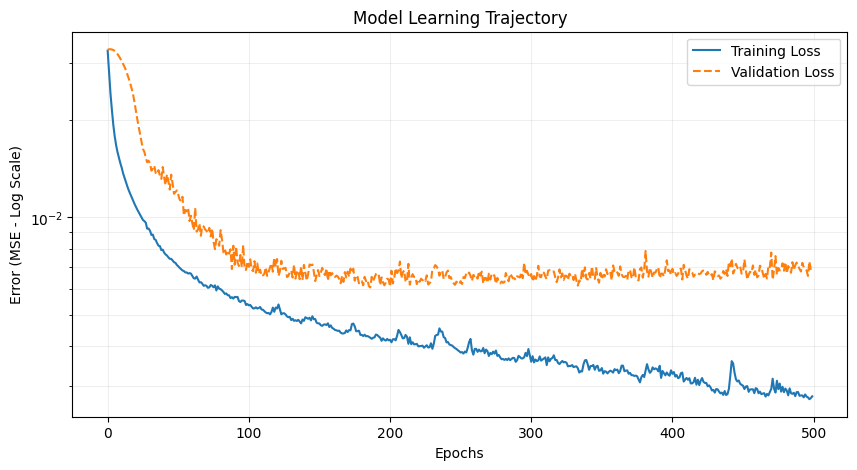

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss", linestyle="--")
plt.yscale('log') #makes small errors visible
plt.xlabel("Epochs")
plt.ylabel("Error (MSE - Log Scale)")
plt.title("Model Learning Trajectory")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    all_preds = model(X_test_gpu)

Y_truth = Y_test_gpu.cpu().numpy()
Y_pred_ai = all_preds.cpu().numpy()

X_noisy_high = X_test_gpu[:, 35:].cpu().numpy()

#per sample (row-wise)
mse_unmitigated = ((Y_truth - X_noisy_high) ** 2).mean(axis=1)
mse_ai = ((Y_truth - Y_pred_ai) ** 2).mean(axis=1)

# Summary Stats
avg_noise_error = mse_unmitigated.mean()
avg_ai_error = mse_ai.mean()
improvement_factor = avg_noise_error / avg_ai_error
win_rate = np.sum(mse_ai < mse_unmitigated) / len(mse_ai) * 100

print(f"\nFINAL PERFORMANCE REPORT (Evaluated on {len(mse_ai)} Test Samples)")
print("=" * 60)
print(f"Average Error (Unmitigated): {avg_noise_error:.6f}")
print(f"Average Error (M Model):    {avg_ai_error:.6f}")
print("-" * 60)
print(f"Improvement Factor:       {improvement_factor:.2f}x (Signal is {improvement_factor:.1f} times cleaner)")
print(f"Win Rate:                 {win_rate:.2f}% of circuits improved")
print("=" * 60)



FINAL PERFORMANCE REPORT (Evaluated on 2000 Test Samples)
Average Error (Unmitigated): 0.022488
Average Error (M Model):    0.007032
------------------------------------------------------------
Improvement Factor:       3.20x (Signal is 3.2 times cleaner)
Win Rate:                 84.75% of circuits improved


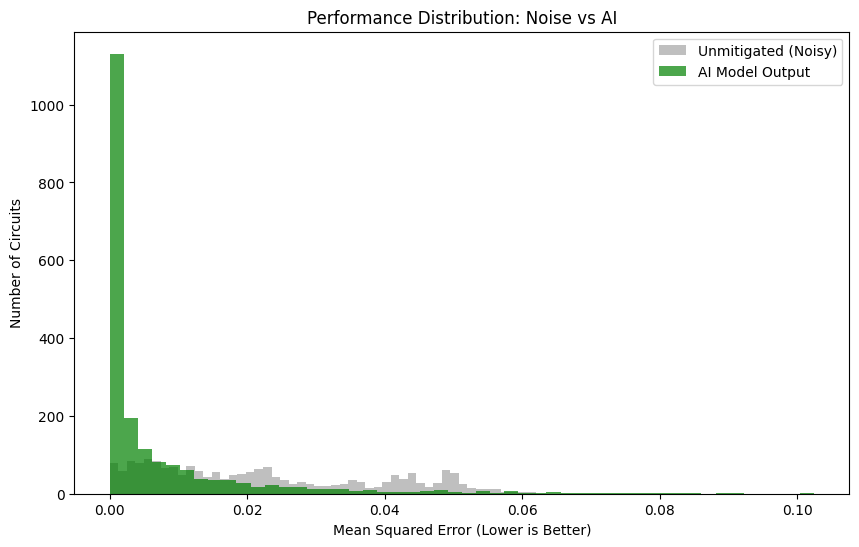


Detailed Check (First 5 Samples)
Metric               | Unmitigated          | AI Model            
-----------------------------------------------------------------
Sample 1 better     | 0.009686             | 0.007027
Sample 2 better     | 0.006657             | 0.000041
Sample 3 better     | 0.016821             | 0.001585
Sample 4 better     | 0.006933             | 0.000126
Sample 5 better     | 0.017550             | 0.000604


In [ ]:

# error histo
plt.figure(figsize=(10, 6))
plt.hist(mse_unmitigated, bins=50, alpha=0.5, label='Unmitigated (Noisy)', color='gray')
plt.hist(mse_ai, bins=50, alpha=0.7, label='AI Model Output', color='green')
plt.xlabel('Mean Squared Error (Lower is Better)')
plt.ylabel('Number of Circuits')
plt.title('Performance Distribution: Noise vs AI')
plt.legend()
plt.show()

# Sample Check
print("\nDetailed Check (First 5 Samples)")
print(f"{'Metric':<20} | {'Unmitigated':<20} | {'AI Model':<20}")
print("-" * 65)
for i in range(5):
    status = "better" if mse_ai[i] < mse_unmitigated[i] else "not"
    print(f"Sample {i+1} {status}     | {mse_unmitigated[i]:.6f}             | {mse_ai[i]:.6f}")

Save model

In [ ]:
MODEL_PATH = "mitigator.pt"
torch.save(model.state_dict(), MODEL_PATH)


In [ ]:
import numpy as np
from itertools import product

def counts_to_probs(counts: dict, n_qubits: int):
    keys = [''.join(bits) for bits in product('01', repeat=n_qubits)]
    shots = sum(counts.values())
    probs = np.array([counts.get(k, 0) for k in keys], dtype=np.float32)
    return probs / max(shots, 1), shots, keys

def probs_to_counts(probs: np.ndarray, shots: int, keys: list):
    probs = np.clip(probs, 0.0, 1.0)
    probs = probs / probs.sum() if probs.sum() > 0 else probs
    counts = (probs * shots).round().astype(int)

    # fix rounding mismatch so total equals shots
    diff = shots - counts.sum()
    if diff != 0:
        idx = np.argmax(probs)  # adjust the most likely outcome
        counts[idx] += diff

    return {k: int(c) for k, c in zip(keys, counts) if c > 0}


In [ ]:
class ErrorMitigationAgent:
    def __init__(self, model, device="cpu", num_features=51, output_mode="vector"):
        self.model = model.to(device)
        self.device = device
        self.num_features = num_features
        self.output_mode = output_mode
        self.model.eval()

    def mitigate(self, noisy_features):
        x = np.asarray(noisy_features, dtype=np.float32)

        if x.shape[0] != self.num_features:
            raise ValueError(f"Expected {self.num_features} features, got {x.shape[0]}")

        x_t = torch.tensor(x, dtype=torch.float32, device=self.device).unsqueeze(0)

        with torch.no_grad():
            y_t = self.model(x_t)

        y = y_t.squeeze(0).detach().cpu().numpy()
        return y

    @staticmethod
    def to_probs(vec):
        t = torch.tensor(vec, dtype=torch.float32)
        p = torch.softmax(t, dim=-1).numpy()
        return p

    def mitigate_counts(self, counts: dict, n_qubits: int):
      # counts -> probs (features)
      probs, shots, keys = counts_to_probs(counts, n_qubits)  # you already saw this pattern

      # NN inference
      mitigated_probs = self.mitigate(probs)

      # Ensure valid distribution
      mitigated_probs = np.maximum(mitigated_probs, 0)
      mitigated_probs = mitigated_probs / mitigated_probs.sum()

      # probs -> counts
      mitigated_counts = probs_to_counts(mitigated_probs, shots, keys)
      return mitigated_probs, mitigated_counts

### Example Usage in a Separate Notebook

To use the `ErrorMitigationAgent` in a different notebook, you would typically:
1. Ensure PyTorch and other necessary libraries are imported.
2. Define the `QuantumErrorMitigator` model architecture (as it's needed to load the state dictionary).
3. Load the saved model state dictionary.
4. Define the `ErrorMitigationAgent` class.
5. Instantiate the `ErrorMitigationAgent` and call its `mitigate_error` method.

In [ ]:
import torch
import torch.nn as nn
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

# Model definition (must match the trained model)
class QuantumErrorMitigator(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(51, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Linear(256, 16),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.net(x)

# Load trained weights
MODEL_PATH = "mitigator.pt"
loaded_model = QuantumErrorMitigator().to(device)

try:
    loaded_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    print(f"Model loaded from {MODEL_PATH}")
except FileNotFoundError:
    print(f"Model file not found at {MODEL_PATH}")
    raise


class ErrorMitigationAgent:
    def __init__(self, model):
        self.model = model

    def mitigate_error(self):
        user_input = input("Enter noisy measurement data (comma-separated): ")

        try:
            input_data = np.array(
                [float(x.strip()) for x in user_input.split(",")],
                dtype=np.float32
            )

            if input_data.shape[0] != 51:
                print(f"Expected 51 values, got {input_data.shape[0]}")
                if input_data.shape[0] < 51:
                    input_data = np.pad(input_data, (0, 51 - input_data.shape[0]))
                else:
                    input_data = input_data[:51]

            input_tensor = torch.tensor(input_data).unsqueeze(0).to(device)

            self.model.eval()
            with torch.no_grad():
                output = self.model(input_tensor)

            result = output.cpu().numpy()
            print("Mitigated output:")
            print(result)
            return result

        except ValueError:
            print("Input must be numeric values separated by commas.")
            return None
        except Exception as e:
            print(f"Mitigation failed: {e}")
            return None


mitigation_agent_new_notebook = ErrorMitigationAgent(loaded_model)

# To test:
# mitigation_agent_new_notebook.mitigate_error()


Using Device: cpu
Model loaded successfully from mitigator.pt


In [ ]:
# Quick test with dummy noisy data

# Create a sample noisy input (length must be 51)
test_noisy_input = np.random.rand(51).astype(np.float32)

# Convert to tensor and run through the model directly
loaded_model.eval()
with torch.no_grad():
    test_tensor = torch.tensor(test_noisy_input).unsqueeze(0).to(device)
    test_output = loaded_model(test_tensor)

print("Test input shape:", test_noisy_input.shape)
print("Model output shape:", test_output.shape)
print("Mitigated output:")
print(test_output.cpu().numpy())


Test input shape: (51,)
Model output shape: torch.Size([1, 16])
Mitigated output:
[[3.3314259e-21 1.8964553e-14 2.2280616e-08 4.1678098e-12 7.8446400e-21
  3.7415005e-11 4.3961390e-18 1.0000000e+00 3.0614932e-25 1.9107894e-26
  7.5260249e-24 1.7361236e-15 1.2834208e-26 1.1455505e-26 9.1506461e-24
  9.0263863e-10]]
